In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import os

%matplotlib inline

In [2]:
TRAIN = pd.read_csv("train.csv")
KAGGLE_TEST = pd.read_csv("test.csv")

In [3]:
TRAIN.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [4]:
KAGGLE_TEST.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
# Removing Outliers
q75, q25 = np.percentile(TRAIN['count'], [75 ,25])
iqr = q75 - q25
print "Q1: {0}, Q3: {1}, IQR: {2}".format(q25, q75, iqr)
# (Q3+β∗IQR,Q1−β∗IQR)
lower = q25 - 1.5 * iqr
upper = q75 + 1.5 * iqr
print "Outliers: Less than {0}, Greater than {1}".format(lower, upper)
print "Original Training Set", TRAIN.shape
print "Training Set after Outlier Removal", TRAIN[(TRAIN['count'] > lower) & (TRAIN['count'] < upper)].shape
#TRAIN = TRAIN[(TRAIN['count'] > lower) & (TRAIN['count'] < upper)]

Q1: 42.0, Q3: 284.0, IQR: 242.0
Outliers: Less than -321.0, Greater than 647.0
Original Training Set (10886, 12)
Training Set after Outlier Removal (10583, 12)


In [6]:
TRAIN.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
def peakhour(row):
    if row['workingday'] == 1 and (7 <= row['hour'] <= 9 or 16 <= row['hour'] <= 20):
        return 1
    else:
        return 0

In [8]:
def year_month(row):
    ret = 0
    if row['year'] == 2011:
        ret = 1
    if row['year'] == 2011 and row['month'] > 3:
        ret = 2
    if row['year'] == 2011 and row['month'] > 6:
        ret = 3
    if row['year'] == 2011 and row['month'] > 9:
        ret = 4
    if row['year'] == 2012:
        ret = 5
    if row['year'] == 2012 and row['month'] > 3:
        ret = 6
    if row['year'] == 2012 and row['month'] > 6:
        ret = 7
    if row['year'] == 2012 and row['month'] > 9:
        ret = 8
    return ret

In [9]:
def feature_extraction(df):
    # Copy the DataFrame (TODO)
    dataframe = df.copy(deep=True)
    '''Engineer Features from Data'''
    '''Break Date Time into multiple features: year, month, day, hour etc'''
    dataframe.index = pd.to_datetime(dataframe['datetime']) # creating an index from the timestamp
    dataframe['year']= dataframe.index.year # year
    dataframe['month'] = dataframe.index.month # month
    dataframe['hour'] = dataframe.index.hour # hours
    dataframe['day'] = dataframe.index.dayofweek # day of week (Monday=0, Sunday=6)
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['week'] = dataframe.index.week
    dataframe['quarter'] = dataframe.index.quarter 

    # Weather
    #weather_dummies = pd.get_dummies(dataframe['weather'], prefix='weather')
    #dataframe = pd.concat([dataframe, weather_dummies], axis=1)

    dataframe['weather1'] = dataframe['weather'].map(lambda x: 1 if x == 1 else 0)
    dataframe['weather2'] = dataframe['weather'].map(lambda x: 1 if x == 2 else 0)
    dataframe['weather3'] = dataframe['weather'].map(lambda x: 1 if x == 3 else 0)
    dataframe['weather4'] = dataframe['weather'].map(lambda x: 1 if x == 4 else 0)

    # Season
    #season_dummies = pd.get_dummies(dataframe['season'], prefix='season')
    #dataframe = pd.concat([dataframe, season_dummies], axis=1)

    dataframe['season1'] = dataframe['season'].map(lambda x: 1 if x == 1 else 0)
    dataframe['season2'] = dataframe['season'].map(lambda x: 1 if x == 2 else 0)
    dataframe['season3'] = dataframe['season'].map(lambda x: 1 if x == 3 else 0)
    dataframe['season4'] = dataframe['season'].map(lambda x: 1 if x == 4 else 0)
    
    # Temperature
    dataframe['temp1'] = dataframe['temp'].map(lambda x: 1 if x <= 12 else 0)
    dataframe['temp2'] = dataframe['temp'].map(lambda x: 1 if 13 <= x <= 25 else 0)
    dataframe['temp3'] = dataframe['temp'].map(lambda x: 1 if 26 <= x <= 33 else 0)
    dataframe['temp4'] = dataframe['temp'].map(lambda x: 1 if x >= 34  else 0)
    
    # Humidity
    dataframe['humidity1'] = dataframe['humidity'].map(lambda x: 1 if x <= 25 else 0)
    dataframe['humidity2'] = dataframe['humidity'].map(lambda x: 1 if 26 <= x <= 50 else 0)
    dataframe['humidity3'] = dataframe['humidity'].map(lambda x: 1 if 51 <= x <= 75 else 0)
    dataframe['humidity4'] = dataframe['humidity'].map(lambda x: 1 if x >= 76  else 0)

    # Sunday (Registered: Least # of Bikes Rented on Sundays)
    dataframe['sunday'] = dataframe['day'].map(lambda x: 1 if x == 6 else 0)
     # Sunday (Registered: Highest # of Bikes Rented on Sundays)
    dataframe['saturday'] = dataframe['day'].map(lambda x: 1 if x == 5 else 0)
    # Weekend
    dataframe['weekend'] = dataframe['day'].map(lambda x: 1 if x == 5 or x == 6 else 0)

    # Bucket Hours of Day
    #labels = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23']
    #lens['age_group'] = pd.cut(dataframe.hour, range(0, 23, 6), right=False, labels=labels)
    dataframe['hour_0_3'] = dataframe['hour'].map(lambda x: 1 if 0 <= x <= 3 else 0)
    dataframe['hour_4_7'] = dataframe['hour'].map(lambda x: 1 if 4 <= x <= 7 else 0)
    dataframe['hour_8_11'] = dataframe['hour'].map(lambda x: 1 if 8 <= x <= 11 else 0)
    dataframe['hour_12_15'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 15 else 0)
    dataframe['hour_16_19'] = dataframe['hour'].map(lambda x: 1 if 16 <= x <= 19 else 0)
    dataframe['hour_20_23'] = dataframe['hour'].map(lambda x: 1 if 20 <= x <= 23 else 0)

    # Peak Hours (Morning & Eve) - Registered
    dataframe['peakhours'] = dataframe.apply(peakhour, axis=1)
    # Peak Hours - Rush Hour for Casual
    dataframe['peakhours_cas'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 18 else 0)
    
    # Year/Month
    dataframe['year_month'] = dataframe.apply(year_month, axis=1)
    
    # Year
    dataframe['year_2011'] = dataframe['year'].map(lambda x: 1 if x == 2011 else 0)
    dataframe['year_2012'] = dataframe['year'].map(lambda x: 1 if x == 2012 else 0)

    return dataframe

In [10]:
def feature_selection(training, kaggle_test=KAGGLE_TEST):
    '''Select Features from Data'''
    '''
    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'year', 'month', 'hour', 'day', 'dayofyear', 'week', 'quarter',
                'weather1', 'weather2', 'weather3', 'weather4',
                'season1', 'season2', 'season3', 'season4', 'sunday',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23']


    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'year', 'month', 'day', 'dayofyear', 'week',
                'weather1', 'weather2', 'weather3', 'weather4',
                'season1', 'season2', 'season3', 'season4', 'sunday',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23']
    '''
    # Separate Features for Count, Registered & Casual
    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'month', 'hour', 'day', 'dayofyear', 'week', 'quarter',
                'year_2011', 'year_2012', 'hour_16_19']

    features_r = ['season', 'workingday',
                  'temp', 'atemp', 'windspeed', 'humidity',
                  'weather1', 'weather2', 'weather3', 'weather4',
                  'temp1', 'temp2', 'temp3', 'temp4',
                'month', 'hour', 'day', 'dayofyear',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
                'year', 'year_month', 'sunday', 'peakhours']

    features_c = ['season', 'holiday', 
                  'temp', 'atemp', 'windspeed', 'humidity',
                  'weather1', 'weather2', 'weather3', 'weather4',
                  'temp1', 'temp2', 'temp3', 'temp4',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
                'month', 'hour', 'peakhours_cas', 'day', 'dayofyear',
                'year', 'year_month', 'weekend']

    return (features, features_r, features_c)

In [11]:
##RMSLE Score Function (for Kaggle Evaluation)
def RMSLE_score(Y_pred, Y_act):
    a = (np.log(Y_pred+1)-np.log(Y_act+1))
    b = 1./len(Y_pred)
    score = (b*sum(a**(2)))**(0.5)
    return score


def RMSE_score(log_Y_pred, log_Y_act):
    n = len(log_Y_pred)
    return np.sqrt(1/n*(np.sum((log_Y_pred-log_Y_act)**2)))

def inv_log(a):
    return np.exp(a)-1

In [12]:
# Kaggle Baseline
def generate_kaggle_submission(pred, f_name):
    print "\n\n Generating Kaggle Submission File: %s" % (f_name)
    print "Shape of Kaggle Test Set: ", KAGGLE_TEST.shape
    print "Shape of Kaggle Test Set Prediction: ", pred.shape
    print pred
    pred = np.rint(pred)
    pred = np.where(pred < 0, 0, pred)
    df_pred = pd.DataFrame(pred, columns=['count'])

    df_dt = pd.DataFrame(KAGGLE_TEST['datetime'])
    df_dt.reset_index(drop=True, inplace=True)

    print df_dt.head()
    print df_pred.head()

    output = pd.concat([df_dt, df_pred], axis=1)
    print "Shape of Submission Dataframe: ", output.shape
    print output.head()

    file = [os.getcwd(),'/submissions/',f_name]
    output.to_csv("".join(file), index=False)

In [13]:
TRAIN_FX = feature_extraction(TRAIN)
KAGGLE_TEST_FX = feature_extraction(KAGGLE_TEST)

(features, features_r, features_c) = feature_selection(TRAIN_FX, KAGGLE_TEST_FX)

Y_COUNT = np.log(TRAIN_FX['count'] + 1)

TRAIN_FX_FS_R = TRAIN_FX[features_r]
KAGGLE_TEST_FX_FS_R = KAGGLE_TEST_FX[features_r]
Y_R = np.log(TRAIN_FX['registered'] + 1)
X_R = TRAIN_FX_FS_R.values
X1_R = KAGGLE_TEST_FX_FS_R.values

TRAIN_FX_FS_C = TRAIN_FX[features_c]
KAGGLE_TEST_FX_FS_C = KAGGLE_TEST_FX[features_c]
Y_C = np.log(TRAIN_FX['casual'] + 1)
X_C = TRAIN_FX_FS_C.values
X1_C = KAGGLE_TEST_FX_FS_C.values

## Random Forest Regressor with Cross Validation
* Separate Models for Registered & Casual


 [Iteration:1] Num of Training: 8164,  Num of Test: 2722
OOB Score (Registered, Casual): 0.96, 0.90
[TRAIN] Residual sum of squares (Count, Registered, Casual): 265.33, 185.78, 35.94
[TEST] Residual sum of squares (Count, Registered, Casual): 1848.82, 1295.42, 228.48
[TEST] R^2 - Variance score (Count, Registered, Casual): 0.93, 0.95, 0.90
[TEST] RMSLE score (Count, Registered, Casual): 0.30, 0.30, 0.47

 [Iteration:2] Num of Training: 8164,  Num of Test: 2722
OOB Score (Registered, Casual): 0.96, 0.90
[TRAIN] Residual sum of squares (Count, Registered, Casual): 279.18, 198.14, 37.19
[TEST] Residual sum of squares (Count, Registered, Casual): 1554.44, 1087.78, 196.24
[TEST] R^2 - Variance score (Count, Registered, Casual): 0.93, 0.95, 0.91
[TEST] RMSLE score (Count, Registered, Casual): 0.29, 0.30, 0.46

 [Iteration:3] Num of Training: 8164,  Num of Test: 2722
OOB Score (Registered, Casual): 0.95, 0.90
[TRAIN] Residual sum of squares (Count, Registered, Casual): 281.67, 197.53, 35.14


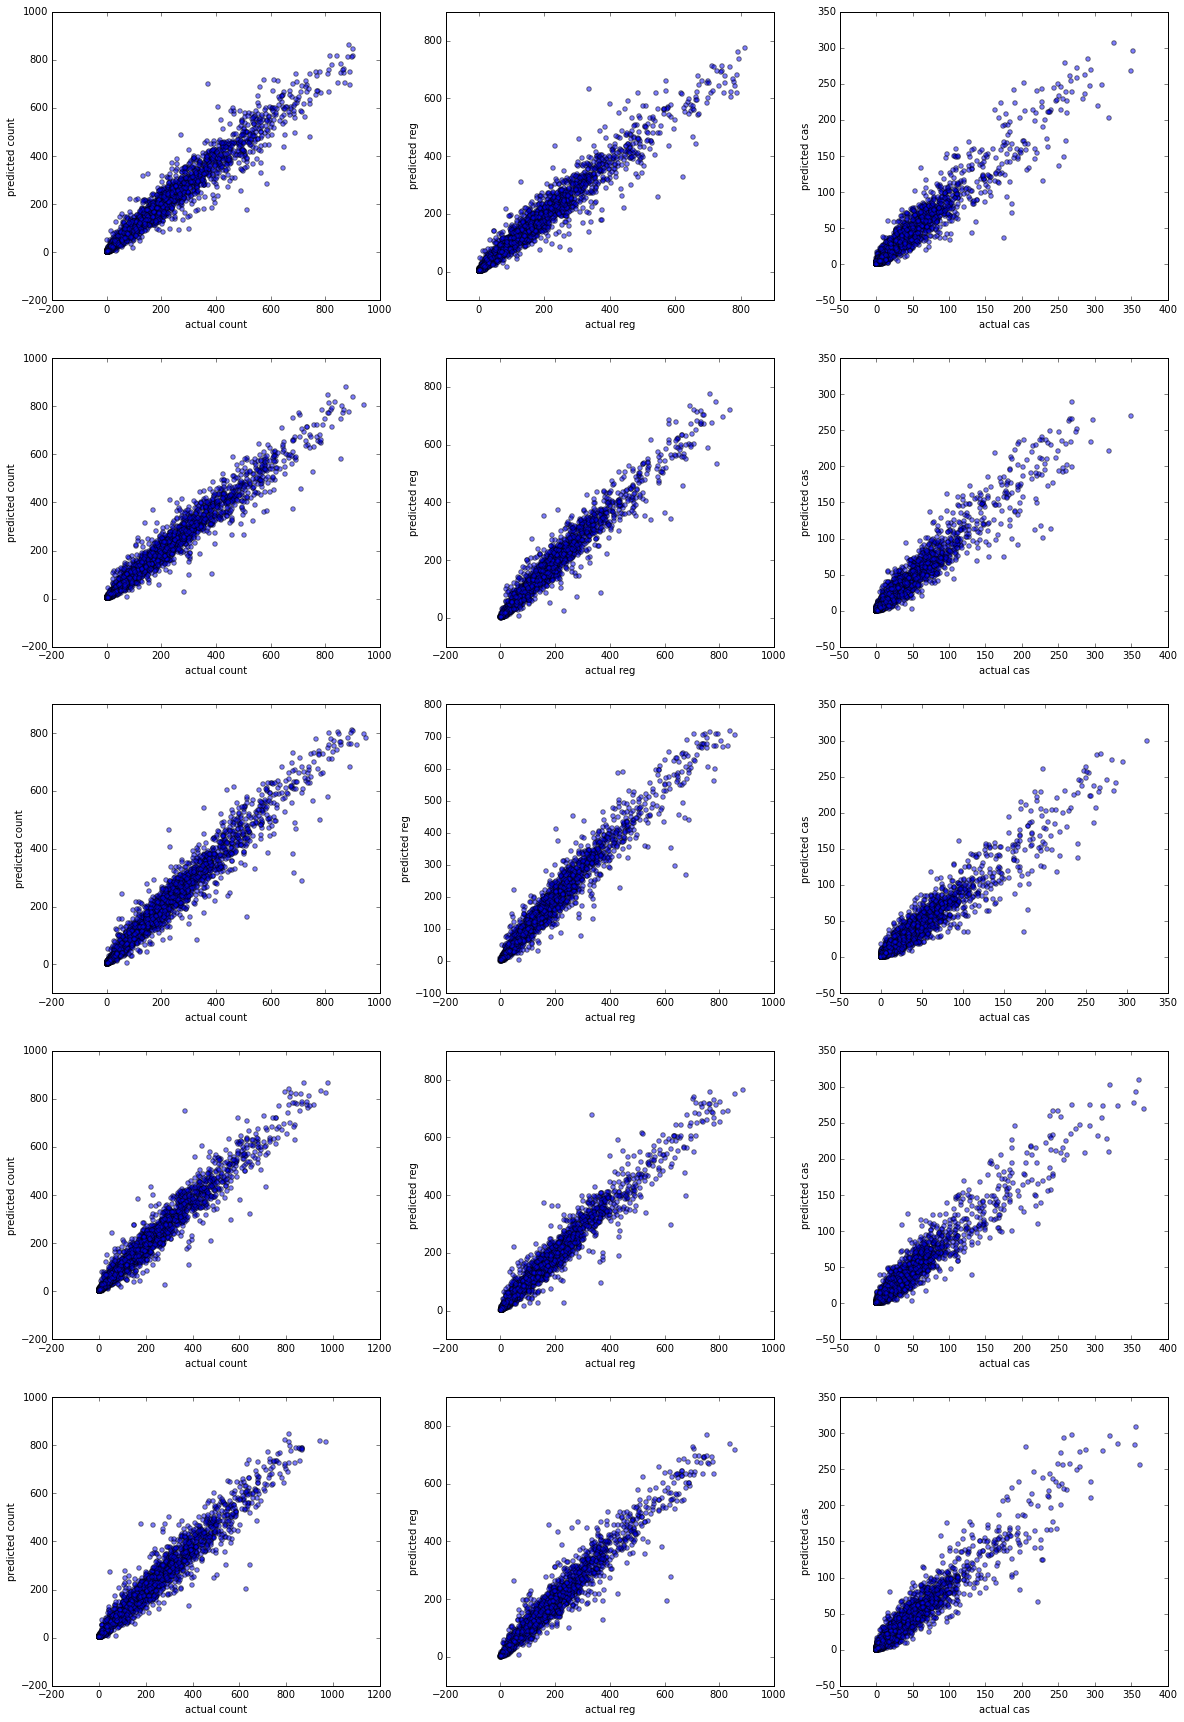

In [21]:
#  Random Forrest with Cross Validation
n_estimators = 200
max_features = 9
#sample_leaf_options = [1,5,10, 25, 50,100,200,500]
n_iter = 5
rows = n_iter
cols = 3
cnt = 1
fig = plt.figure(figsize=(20, 30), dpi=80)
ax1 = fig.add_subplot(rows, cols, cnt)

rf_reg = ensemble.RandomForestRegressor(n_estimators=n_estimators, 
                                        max_features=max_features,
                                        oob_score=True,
                                        n_jobs=-1)
rf_cas = ensemble.RandomForestRegressor(n_estimators=n_estimators, 
                                        max_features=max_features,
                                        oob_score=True,
                                        n_jobs=-1)

'''
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
rf_reg = ensemble.GradientBoostingRegressor(**params)
rf_cas = ensemble.GradientBoostingRegressor(**params)
'''

ss = cross_validation.ShuffleSplit(X_R.shape[0], n_iter=n_iter, test_size=0.25, random_state=0)
count = 1
for train_index, test_index in ss:
    print("\n [Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))

    # Train the model using the training sets
    rf_reg.fit(X_R[train_index], Y_R[train_index])

     # Train the model using the training sets
    rf_cas.fit(X_C[train_index], Y_C[train_index])

    # Train
    pred_reg_train = inv_log(rf_reg.predict(X_R[train_index]))
    pred_cas_train = inv_log(rf_cas.predict(X_C[train_index]))
    predictions_train = pred_reg_train + pred_cas_train

    # Test
    pred_reg = inv_log(rf_reg.predict(X_R[test_index]))
    pred_cas = inv_log(rf_cas.predict(X_C[test_index]))
    predictions = pred_reg + pred_cas
    
    ax1 = fig.add_subplot(rows, cols, cnt)
    ax1.set_xlabel("actual count")
    ax1.set_ylabel("predicted count")
    ax1.scatter(inv_log(Y_COUNT[test_index]), predictions, alpha=0.5)
    cnt += 1 
    
    ax2 = fig.add_subplot(rows, cols, cnt)
    ax2.set_xlabel("actual reg")
    ax2.set_ylabel("predicted reg")
    ax2.scatter(inv_log(Y_R[test_index]), pred_reg, alpha=0.5)
    cnt += 1 
    
    ax3 = fig.add_subplot(rows, cols, cnt)
    ax3.set_xlabel("actual cas")
    ax3.set_ylabel("predicted cas")
    ax3.scatter(inv_log(Y_C[test_index]), pred_cas, alpha=0.5)
    cnt += 1 

    print ("OOB Score (Registered, Casual): %.2f, %.2f" % (rf_reg.oob_score_, rf_cas.oob_score_))
    
    # The mean square error
    ss_r = np.mean((np.rint(pred_reg_train) - inv_log(Y_R[train_index])) ** 2)
    ss_c = np.mean((np.rint(pred_cas_train) - inv_log(Y_C[train_index])) ** 2)
    ss = np.mean((np.rint(predictions_train) - inv_log(Y_COUNT[train_index])) ** 2)
    print("[TRAIN] Residual sum of squares (Count, Registered, Casual): %.2f, %.2f, %.2f"
          % (ss, ss_r, ss_c))
    
    ss_r = np.mean((np.rint(pred_reg) - inv_log(Y_R[test_index])) ** 2)
    ss_c = np.mean((np.rint(pred_cas) - inv_log(Y_C[test_index])) ** 2)
    ss = np.mean((np.rint(predictions) - inv_log(Y_COUNT[test_index])) ** 2)
    print("[TEST] Residual sum of squares (Count, Registered, Casual): %.2f, %.2f, %.2f"
          % (ss, ss_r, ss_c))
    
    # Explained variance score: 1 is perfect prediction
    r_squared_r = rf_reg.score(X_R[test_index], Y_R[test_index])
    r_squared_c = rf_cas.score(X_C[test_index], Y_C[test_index])
    r_squared = ( r_squared_r +  r_squared_c) / 2
    print('[TEST] R^2 - Variance score (Count, Registered, Casual): %.2f, %.2f, %.2f' % (r_squared, r_squared_r, r_squared_c))

    # RMSLE Kaggle
    # root mean square log error
    predictions[predictions < 0] = 0
    pred_reg[pred_reg < 0] = 0
    pred_cas[pred_cas < 0] = 0
    rmsle_r = RMSLE_score(pred_reg, inv_log(Y_R[test_index]))
    rmsle_c = RMSLE_score(pred_cas, inv_log(Y_C[test_index]))
    rmsle = RMSLE_score(predictions, inv_log(Y_COUNT[test_index]))
    print "[TEST] RMSLE score (Count, Registered, Casual): %.2f, %.2f, %.2f" % (rmsle, rmsle_r, rmsle_c)
    
    # Analyse Differences
    df = TRAIN.loc[test_index].copy(deep=True)
    df['pred_cas'] = pred_cas
    df['pred_reg'] = pred_reg
    df['pred_count'] = predictions
    df['delta_cas'] = np.absolute(df['pred_cas'] - df['casual'])
    df['delta_reg'] = np.absolute(df['pred_reg'] - df['registered'])
    df['delta_count'] = np.absolute(df['pred_count'] - df['count'])
    df.sort(['delta_count'], ascending=False, inplace=True)
    #df.head(5)

    file = [os.getcwd(),'/submissions/','analyze_predictions_', str(count), '.xls']
    df.to_excel ("".join(file), sheet_name='Sheet1')

    count += 1





[Registered] Feature ranking:
1. Feature 15 - hour : (0.248755)
2. Feature 18 - hour_0_3 : (0.177730)
3. Feature 27 - peakhours : (0.129072)
4. Feature 19 - hour_4_7 : (0.108048)
5. Feature 1 - workingday : (0.040690)
6. Feature 22 - hour_16_19 : (0.035958)
7. Feature 25 - year_month : (0.026348)
8. Feature 20 - hour_8_11 : (0.024738)
9. Feature 24 - year : (0.022055)
10. Feature 16 - day : (0.021427)
11. Feature 21 - hour_12_15 : (0.020073)
12. Feature 10 - temp1 : (0.017315)
13. Feature 3 - atemp : (0.014497)
14. Feature 17 - dayofyear : (0.014147)
15. Feature 2 - temp : (0.013962)
16. Feature 5 - humidity : (0.013367)
17. Feature 14 - month : (0.012061)
18. Feature 0 - season : (0.010491)
19. Feature 8 - weather3 : (0.010188)
20. Feature 26 - sunday : (0.009227)
21. Feature 23 - hour_20_23 : (0.008916)
22. Feature 4 - windspeed : (0.008161)
23. Feature 6 - weather1 : (0.003881)
24. Feature 11 - temp2 : (0.003033)
25. Feature 7 - weather2 : (0.002905)
26. Feature 12 - temp3 : (0.00

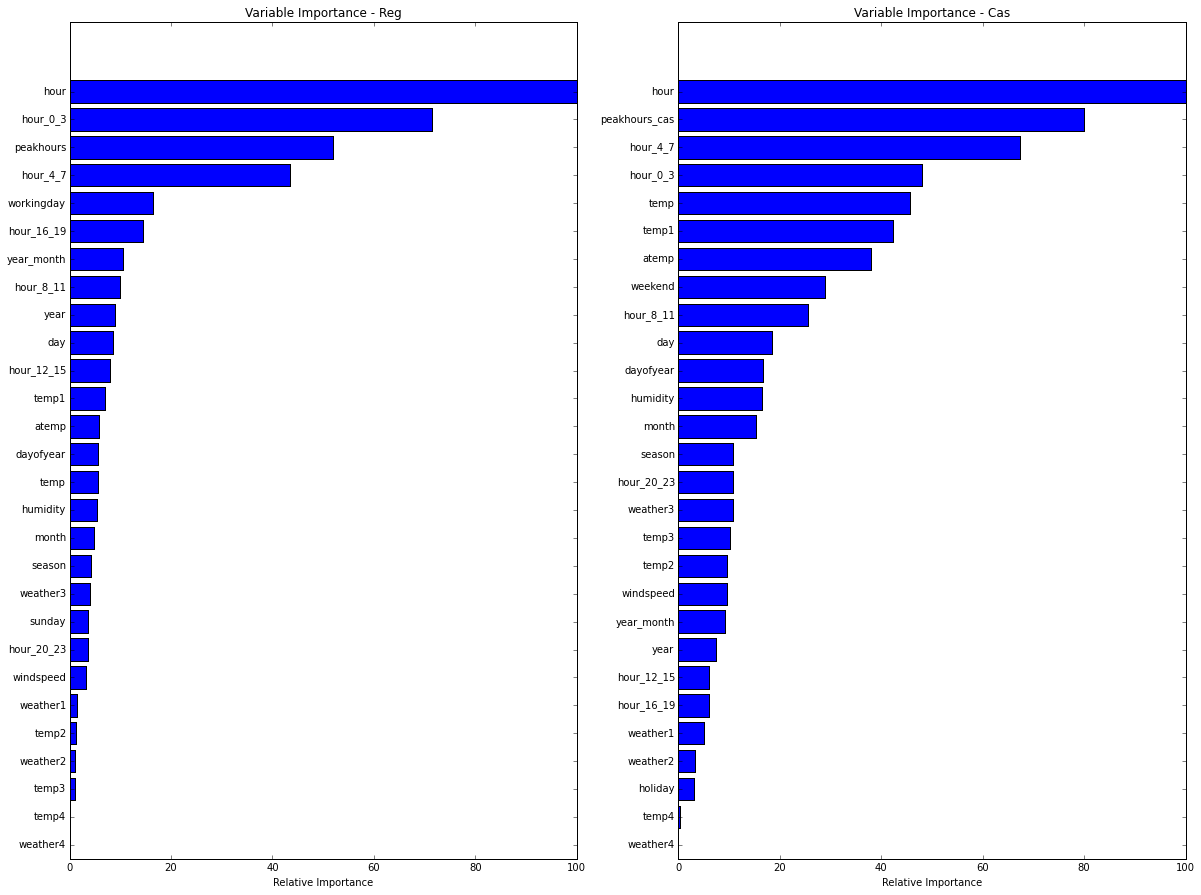



 Generating Kaggle Submission File: rf.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
[   8.83168724    4.80524733    2.68273375 ...,  130.78491975  112.45922024
   75.90027443]
              datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
   count
0      9
1      5
2      3
3      2
4      2
Shape of Submission Dataframe:  (6493, 2)
              datetime  count
0  2011-01-20 00:00:00      9
1  2011-01-20 01:00:00      5
2  2011-01-20 02:00:00      3
3  2011-01-20 03:00:00      2
4  2011-01-20 04:00:00      2


In [20]:
# Train the model using the entire data set (Used to generate Kaggle Submission Later)
rf_reg.fit(X_R, Y_R)
rf_cas.fit(X_C, Y_C)

feature_importances__reg = rf_reg.feature_importances_
#print feature_importances__reg
indices = np.argsort(feature_importances__reg)[::-1]

# Print the feature ranking
print("\n\n[Registered] Feature ranking:")
for f in xrange(len(features_r)):
    print("%d. Feature %d - %s : (%f)" % (f + 1, indices[f],  features_r[indices[f]], feature_importances__reg[indices[f]]))
    
    
feature_importances__cas = rf_cas.feature_importances_
#print feature_importances__cas
indices = np.argsort(feature_importances__cas)[::-1]

# Print the feature ranking
print("\n\n[Casual] Feature ranking:")
for f in xrange(len(features_c)):
    print("%d. Feature %d - %s : (%f)" % (f + 1, indices[f],  features_c[indices[f]], feature_importances__cas[indices[f]]))
    
# Plot feature importance
fig = plt.figure(figsize=(20, 15), dpi=80)
# make importances relative to max importance
feature_importances__reg = 100.0 * (feature_importances__reg / feature_importances__reg.max())
sorted_idx = np.argsort(feature_importances__reg)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importances__reg[sorted_idx], align='center')
plt.yticks(pos, np.array(features_r)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance - Reg')

# make importances relative to max importance
feature_importances__cas = 100.0 * (feature_importances__cas / feature_importances__cas.max())
sorted_idx = np.argsort(feature_importances__cas)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importances__cas[sorted_idx], align='center')
plt.yticks(pos, np.array(features_c)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance - Cas')
plt.show()


pred_reg = inv_log(rf_reg.predict(X1_R))
pred_cas = inv_log(rf_cas.predict(X1_C))
predictions = pred_reg + pred_cas

# Kaggle Submission
generate_kaggle_submission(predictions, "rf.csv")

## Random Forest Regressor with Grid Search (Doesn't work - sklearn bug?)
* Separate Models for Registered & Casual

In [ ]:
# Define A Pipeline
pipeline = Pipeline([
        ('clf', ensemble.RandomForestRegressor(criterion='mse'))
])

# Hyperparameters for Estimators in Pipeline
parameters = {
    'clf__n_estimators': (100, 200, 250, 500),
    'clf__max_depth': (10, 25, 50, 100, 150, 200),
    'clf__max_features': (7,8,9,10,11,12,13,'sqrt','log2','auto'),
    'clf__min_samples_split': (1, 2, 3),
    'clf__min_samples_leaf': (1, 2, 3),
    'clf__oob_score': (True, False)
}

# Shuffle once before splitting into reg/cas train & test sets
TRAIN_FX = TRAIN_FX.reindex(np.random.permutation(TRAIN_FX.index))
(features, features_r, features_c) = feature_selection(TRAIN_FX, KAGGLE_TEST_FX)
print TRAIN_FX.shape

# Split into Train/Test
X_train = TRAIN_FX[:8500]
X_test = TRAIN_FX[8500:]

# Count
y_test_count = np.log(X_test['count'] + 1)

# Reg
X_train_reg = X_train[features_r].values
y_train_reg = np.log(X_train['registered'].values + 1)
X_test_reg = X_test[features_r].values
y_test_reg = np.log(X_test['registered'].values + 1)
print '[REG]', X_train_reg.shape, X_test_reg.shape
print y_train_reg

# Cas
X_train_cas = X_train[features_c].values
#y_train_cas = np.log(X_train['casual'] + 1)
y_train_cas = X_train['casual'] + 1
X_test_cas = X_test[features_c].values
#y_test_cas = np.log(X_test['casual'] + 1)
y_test_cas = X_test['casual']
print '[CAS]', X_train_cas.shape, X_test_cas.shape
print y_train_cas


gs_reg = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')
gs_cas = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')

gs_reg.fit(X_train_reg, y_train_reg)
print '[REG] Best score: %0.3f' % gs_reg.best_score_
print '[REG] Best parameters set:'
best_parameters = gs_reg.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
gs_cas.fit(X_train_cas, y_train_cas)
print '[CAS] Best score: %0.3f' % gs_cas.best_score_
print '[CAS] Best parameters set:'
best_parameters = gs_cas.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])


#pred_reg = inv_log(gs_reg.predict(X_test_reg))
pred_reg = gs_reg.predict(X_test_reg)
print classification_report(y_test_reg, pred_reg)

#pred_cas = inv_log(gs_cas.predict(X_test_cas))
pred_cas = gs_cas.predict(X_test_cas)
print classification_report(y_test_cas, pred_cas)

predictions = pred_reg + pred_cas

# The mean square error
ss_r = np.mean((np.rint(pred_reg) - inv_log(y_test_reg)) ** 2)
ss_c = np.mean((np.rint(pred_cas) - inv_log(y_test_cas)) ** 2)
ss = np.mean((np.rint(predictions) - inv_log(y_test_count)) ** 2)
print("[TEST] Residual sum of squares (Count, Registered, Casual): %.2f, %.2f, %.2f"
      % (ss, ss_r, ss_c))

# Explained variance score: 1 is perfect prediction
r_squared_r = gs_reg.score(X_test_reg, y_test_reg)
r_squared_c = gs_cas.score(X_test_cas, y_test_cas)
r_squared = ( r_squared_r +  r_squared_c) / 2
print('[TEST] R^2 - Variance score (Count, Registered, Casual): %.2f, %.2f, %.2f' % (r_squared, r_squared_r, r_squared_c))

# RMSLE Kaggle
# root mean square log error
predictions[predictions < 0] = 0
pred_reg[pred_reg < 0] = 0
pred_cas[pred_cas < 0] = 0
rmsle_r = RMSLE_score(pred_reg, inv_log(y_test_reg))
rmsle_c = RMSLE_score(pred_cas, inv_log(y_test_cas))
rmsle = RMSLE_score(predictions, inv_log(y_test_count))
print "[TEST] RMSLE score (Count, Registered, Casual): %.2f, %.2f, %.2f" % (rmsle, rmsle_r, rmsle_c)